<a href="https://www.kaggle.com/code/utkarsh1006/aivsreal?scriptVersionId=201939621" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img
warnings.filterwarnings('ignore')

2024-10-18 20:35:53.298296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 20:35:53.298422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 20:35:53.431505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
input_path = []
label = []

for input in os.listdir("/kaggle/input/cynapticsinduction/Train"):
    for path in os.listdir("/kaggle/input/cynapticsinduction/Train/"+input):
        if input == 'AI_Images':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("/kaggle/input/cynapticsinduction/Train/", input, path))
print(input_path[0], label[0])

/kaggle/input/cynapticsinduction/Train/AI_Images/image_561.jpg 0


In [3]:
df = pd.DataFrame()
df['Id'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

Id  label
0  /kaggle/input/cynapticsinduction/Train/AI_Imag...      0
1  /kaggle/input/cynapticsinduction/Train/Real_Im...      1
2  /kaggle/input/cynapticsinduction/Train/AI_Imag...      0
3  /kaggle/input/cynapticsinduction/Train/Real_Im...      1
4  /kaggle/input/cynapticsinduction/Train/AI_Imag...      0

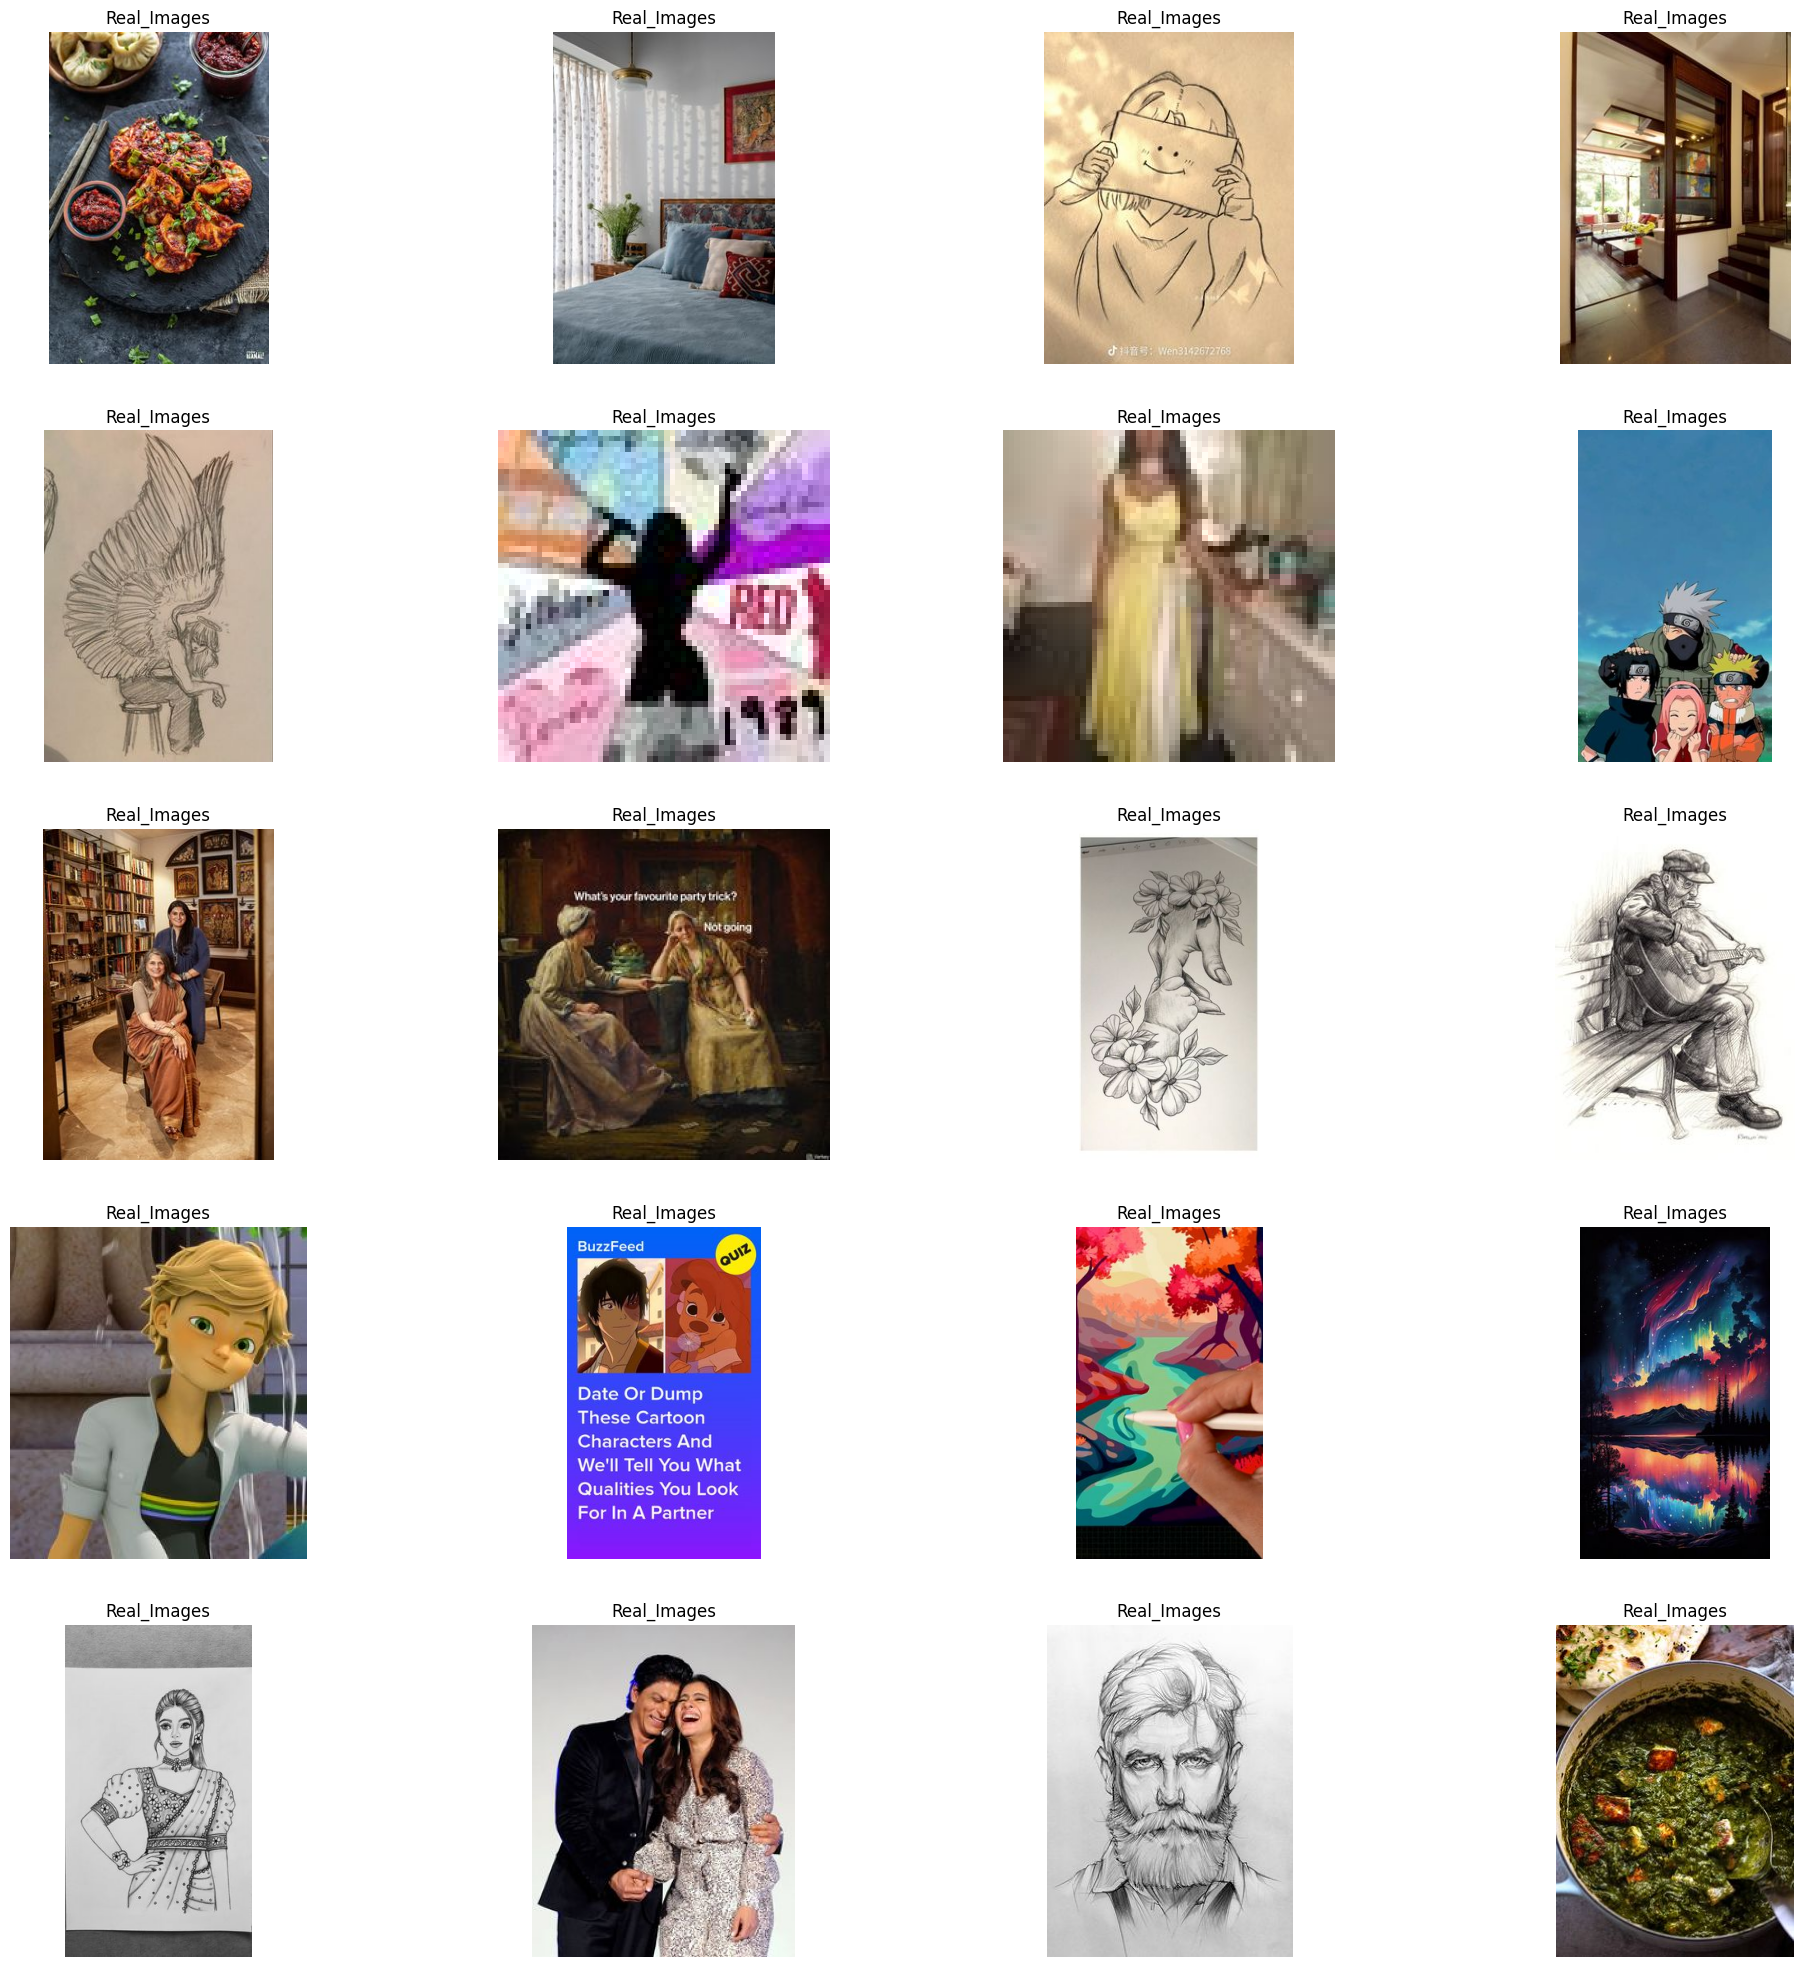

In [4]:
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['Id']
start = random.randint(0, len(temp))
files = temp[start:start+20]

for index, file in enumerate(files):
    plt.subplot(5,4, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Real_Images')
    plt.axis('off')

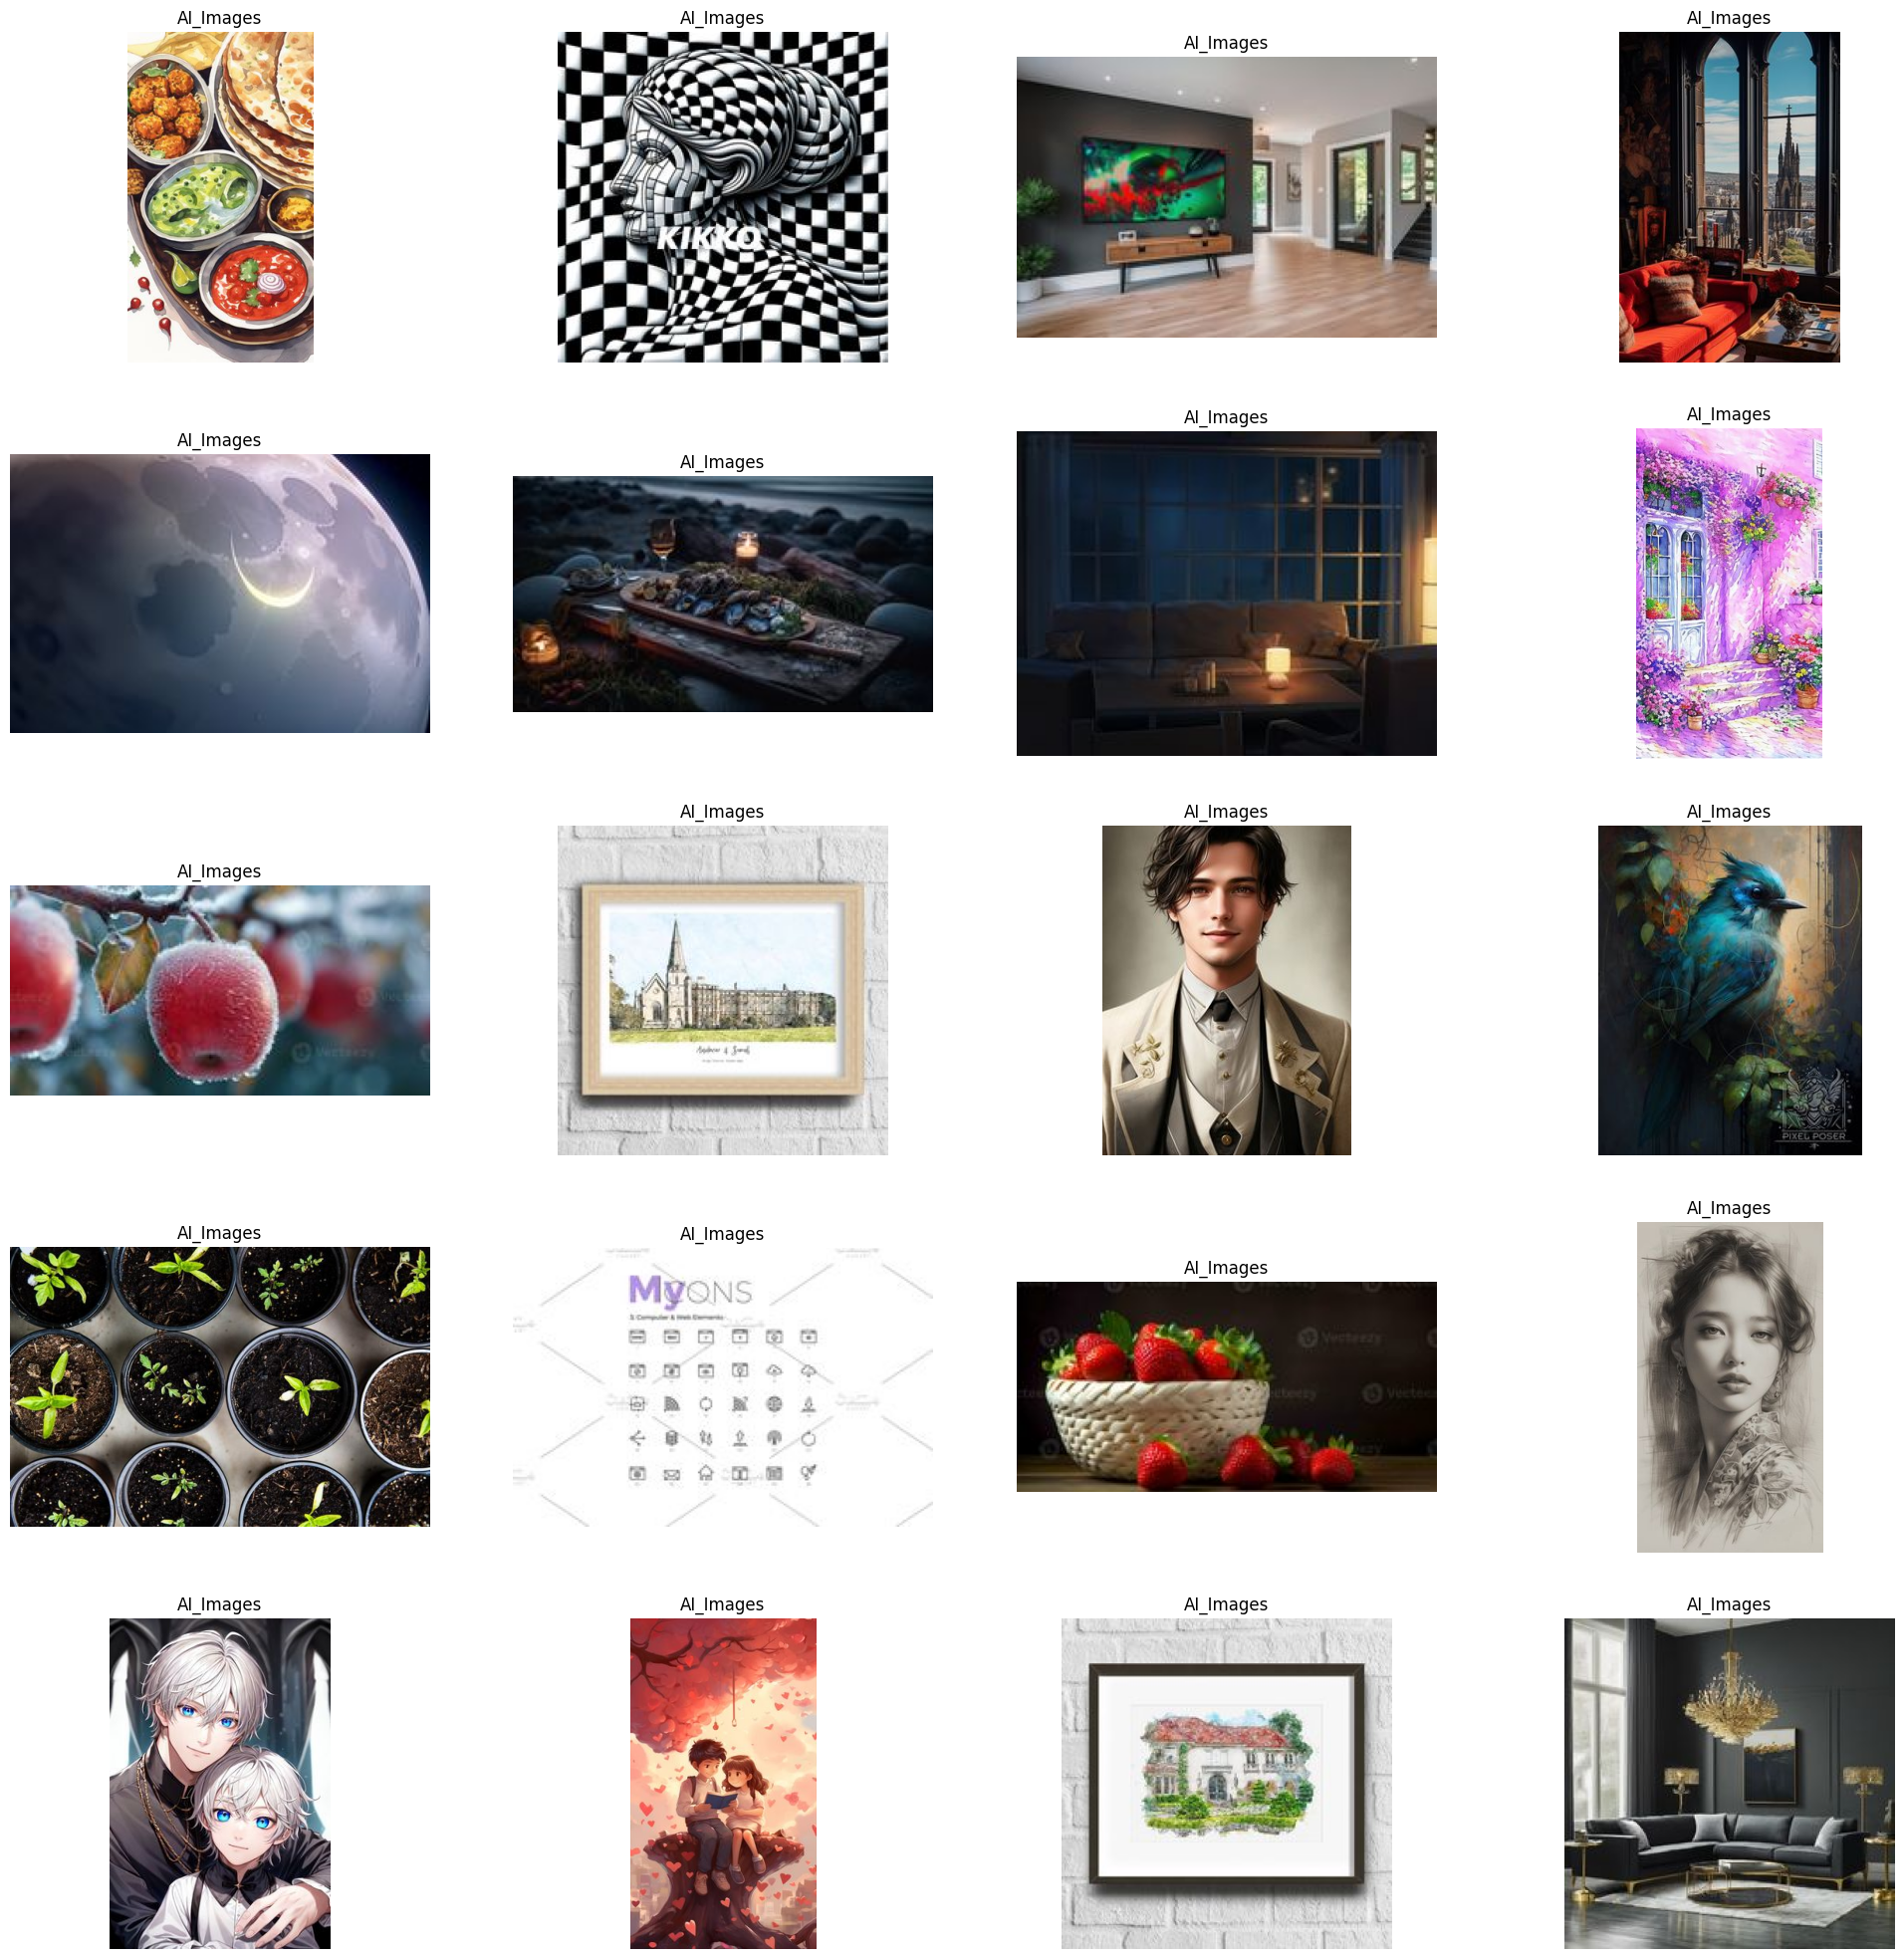

In [5]:
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['Id']
start = random.randint(0, len(temp))
files = temp[start:start+20]

for index, file in enumerate(files):
    plt.subplot(5,4, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('AI_Images')
    plt.axis('off')

In [6]:
df['label'] = df['label'].astype('str')

In [7]:
df.head()

Id label
0  /kaggle/input/cynapticsinduction/Train/AI_Imag...     0
1  /kaggle/input/cynapticsinduction/Train/Real_Im...     1
2  /kaggle/input/cynapticsinduction/Train/AI_Imag...     0
3  /kaggle/input/cynapticsinduction/Train/Real_Im...     1
4  /kaggle/input/cynapticsinduction/Train/AI_Imag...     0

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  
    rotation_range = 40, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'

)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='Id',
    y_col='label',
    target_size=(256,256),
    batch_size=64,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='Id',
    y_col='label',
    target_size=(256,256),
    batch_size=64,
    class_mode='binary'
)

Found 1004 validated image filenames belonging to 2 classes.
Found 251 validated image filenames belonging to 2 classes.


In [10]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout
# feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

model = Sequential([
#     hub.KerasLayer(
#     feature_extractor_model, input_shape=(224, 224, 3), trainable=False),
    Conv2D(16, (3,3), activation='relu',  input_shape=(256,256,3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Conv2D(256, (3,3), activation='relu'),
    MaxPool2D((2,2)),

    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,069,889 (99.45 MB)

 Trainable params: 26,069,889 (99.45 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(train_iterator, epochs=20, validation_data=val_iterator)

Epoch 1/20
 1/16 ━━━━━━━━━━━━━━━━━━━━ 8:17 33s/step - accuracy: 0.5156 - loss: 0.6915

I0000 00:00:1729283811.792036      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1729283811.816214      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4920 - loss: 1.1620

W0000 00:00:1729283837.125710      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.4932 - loss: 1.1482 - val_accuracy: 0.5378 - val_loss: 0.6933
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 597ms/step - accuracy: 0.5361 - loss: 0.6928 - val_accuracy: 0.5418 - val_loss: 0.6928
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 590ms/step - accuracy: 0.5180 - loss: 0.6931 - val_accuracy: 0.5378 - val_loss: 0.6905
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 603ms/step - accuracy: 0.5199 - loss: 0.6926 - val_accuracy: 0.5378 - val_loss: 0.6893
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 588ms/step - accuracy: 0.5208 - loss: 0.6883 - val_accuracy: 0.5339 - val_loss: 0.6733
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 597ms/step - accuracy: 0.5351 - loss: 0.6797 - val_accuracy: 0.6215 - val_loss: 0.6588
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 613ms/step - accuracy: 0.5963 - loss: 0.6690 - val_accuracy: 0.6335 - val_loss: 0.6669
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 598ms/step - accuracy: 0.6070 - loss: 0.6673 - val_accuracy: 0.6295 -

In [13]:

Id=[]
Label=[]
for input in os.listdir("/kaggle/input/cynapticsinduction/Test/Test_Images"):
  image_path = "/kaggle/input/cynapticsinduction/Test/Test_Images/"+input # path of the image
  img = load_img(image_path, target_size=(256, 256))
  img = np.array(img)
  img = img / 255.0 # normalize the image
  img = img.reshape(1, 256, 256, 3) # reshape for prediction
  pred = model.predict(img)
  if pred[0] > 0.5:
      label = 'Real'
      Label.append(label)
  else:
      label = 'AI'
      Label.append(label)
  Id.append(input.replace(".jpg",""))
  print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
AI
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/s

In [14]:
final=pd.DataFrame()
final["Id"] = Id
final["Label"] = Label
final=final.sort_values(by = 'Id')
final.head()

Id Label
303    image_1  Real
170   image_10  Real
425  image_100  Real
212  image_101  Real
344  image_102  Real

In [15]:
final.to_csv("submission2.csv",index=False)